# Lab 6 - Intro to Image Classification with Convolutional Neural Networks


## Background - Image Classification

For this project you will be introduced to the basics of Convolutional Neural Networks (CNNs) and the PyTorch framework.  Deep learning with CNNs can be very computationally expensive and runs fastest with GPU support.  If you do not have access to GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file. If you have a Mac machine that has a M1 or M2 processor, you can also use MPS acceleration for a slight speed up.

Image classification is the task of taking an image and labeling it as a category.  CNNs have been a leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

The instructions for the lab are contained in this Jupyter notebook. **You may choose to complete the lab in this notebook, or you may choose to complete the lab in standard Python using the .py template file.**

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You can download the images and the needed annotation files from this [Google Drive folder](https://drive.google.com/drive/folders/1GLHQAt3KNN_3eIETkinzlY5q9HG44Blx?usp=sharing).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb or .py file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj6-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any neural network method is to make sure you can read in the data.  Since there will be a lot of images for this project, not all of them will fit into memory.  This is a common problem in CNNs and PyTorch has provided a pattern so as to only have the images you need in memory at any given time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`. A template is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). You can also reference the Custom Image Loader found in [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

We provide you with two files `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  

To complete part A, implement a dataset class for the cars dataset.



In [191]:
### TASK 1: Implement Data Loader ###

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms


class MyDataset(Dataset):

    def __init__(self, labels_fn, image_dir, transform=None):
        super(MyDataset, self).__init__()
        # TODO: implement what happens when someone calls: dataset = MyDataset()
        # Pull in relevant file information, images lists, etc.
        with open (labels_fn, 'r') as f:
            self.annotations = json.load(f)
        
        self.image_dir = os.path.join(image_dir, image_dir.split('/')[-1])
        self.image_names = list(self.annotations.keys())
        self.transform = transform 
        
        
        
    def __getitem__(self, idx):
        # TODO: implement what happens when someone calls dataset[idx]
        # Return an image and it's associated label at location idx 
        image_name = self.image_names[idx]
        label = self.annotations[image_name]

        image_path = os.path.join(self.image_dir, image_name)
        image = read_image(image_path, ImageReadMode.RGB) / 255.0

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label - 1, dtype=torch.long)

        return image, label
    
    def __len__(self):
        # TODO: implement what happens when someone calls len(dataset)
        # Determine the number of images in the dataset
        return len(self.image_names)
    
    
    




You can test your dataset loader by running the following code (You don't have to let it run through the whole dataset):

In [192]:
training_dataset = MyDataset("train_annos.json", "cars_train")
loader = DataLoader(training_dataset,batch_size=1)
for im, label in loader:
      print(im.shape,label)

torch.Size([1, 3, 400, 600]) tensor([13])
torch.Size([1, 3, 675, 900]) tensor([2])
torch.Size([1, 3, 480, 640]) tensor([90])
torch.Size([1, 3, 1386, 2100]) tensor([133])
torch.Size([1, 3, 108, 144]) tensor([105])
torch.Size([1, 3, 431, 575]) tensor([122])
torch.Size([1, 3, 480, 640]) tensor([88])
torch.Size([1, 3, 480, 639]) tensor([95])
torch.Size([1, 3, 843, 1280]) tensor([166])
torch.Size([1, 3, 480, 640]) tensor([57])
torch.Size([1, 3, 424, 640]) tensor([48])
torch.Size([1, 3, 315, 500]) tensor([185])
torch.Size([1, 3, 335, 500]) tensor([134])
torch.Size([1, 3, 600, 800]) tensor([84])
torch.Size([1, 3, 424, 640]) tensor([192])
torch.Size([1, 3, 480, 640]) tensor([171])
torch.Size([1, 3, 194, 259]) tensor([13])
torch.Size([1, 3, 147, 200]) tensor([72])
torch.Size([1, 3, 938, 1500]) tensor([191])
torch.Size([1, 3, 650, 1000]) tensor([56])
torch.Size([1, 3, 469, 750]) tensor([78])
torch.Size([1, 3, 1386, 2100]) tensor([35])
torch.Size([1, 3, 270, 500]) tensor([119])
torch.Size([1, 3, 

KeyboardInterrupt: 

**Additional Notes and Tips**:

- Both the images and the labels are 1-indexed. You can load the images however you choose, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

- Make sure the images and labels that are returned are both PyTorch tensors. Specifically, the images should be returned as Tensors that are rearranged to be shape [channels, rows, cols] and should be values between 0 and 1. To guarantee this, I recommend using `read_image` from `torchvision.io` and dividing by 255.

- Some of the images in the dataset are grayscale while most are RGB. To prevent issues later, make sure to load all images as RGB. If you use `read_image`, you can use `ImageReadMode.RGB` to guarantee that all images have 3 channels.

- Python has a [json library](https://docs.python.org/3/library/json.html) that you can use to turn json files in to Python dictionaries. You can look up some simple tutorials online.

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermitted downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. an single image with dimensions 224x224 would be `(1, 3, 224, 224)`) and output a vector of shape `(num_classes,)` where the largest value's index in the output vector indicates the class label.  

While we built our own network in the mini-lab, for this lab, we will use one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:


In [193]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

/opt/anaconda3/envs/compvis/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/compvis/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a common baseline network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [194]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the template provided below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), the Training a Classifier tutorial is especially helpful.

To complete part B, make your own neural network by taking all the pretrained layers from ResNet18, but then defining your own last fully connected layer. Then write the appropriate forward pass function.


In [195]:
### TASK 2: Design Neural Network ###

import torch.nn as nn
import torchvision 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        ref_model = torchvision.models.resnet18(pretrained=True)
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        # TODO: Continue network setup here
        # TODO: Replace fc layer with your own linear layer that outputs 196 classes
        self.maxpool = ref_model.maxpool
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3
        self.layer4 = ref_model.layer4
        self.avgpool = ref_model.avgpool
        self.fc = nn.Linear(512, 196)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # TODO: Continue feeding output through all layers of the network
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) 
        x = self.fc(x)
        return x

An alternative approach to defining the ResNet architecture is to modify the fully connected layer inplace. You are allowed to do this instead for this lab.

You can test that your network is defined correctly by running the following code. The expected output shape is (1,196).

In [196]:
import torch

model = MyNetwork()
test_im = torch.zeros((1,3,256,256))
output = model(test_im)

print(output.shape)

torch.Size([1, 196])


# Part C: Training

Now that you can access your data and you have a network architecture setup, it's time to put things together and start training.  Training requires two major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer function is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

It is common to run through the training data multiple times. Each run through the training data is called an **epoch**. You will only be required to do one epoch, but you may increase the number of epochs to increase the accuracy of the network. 

A basic training loop might take the following form:

In [197]:
### Task 3: Modify the training loop ###
import torch
import matplotlib.pyplot as plt

batch_size = 32

training_dataset = MyDataset("train_annos.json","cars_train")
train_loader = DataLoader(training_dataset,batch_size=1,shuffle=True)

model = MyNetwork()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

losses = []

num_epochs = 1
model.train() 

for epoch in range(num_epochs):
    for batch_idx, (images,labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outs = model(images)
        loss = loss_func(outs, labels)  
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (batch_idx + 1)% 20 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Iteration [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/1], Iteration [20/8144], Loss: 5.4189
Epoch [1/1], Iteration [40/8144], Loss: 5.1505
Epoch [1/1], Iteration [60/8144], Loss: 4.6545
Epoch [1/1], Iteration [80/8144], Loss: 4.5489
Epoch [1/1], Iteration [100/8144], Loss: 6.1732
Epoch [1/1], Iteration [120/8144], Loss: 6.7762
Epoch [1/1], Iteration [140/8144], Loss: 6.0972
Epoch [1/1], Iteration [160/8144], Loss: 6.4918
Epoch [1/1], Iteration [180/8144], Loss: 5.4301
Epoch [1/1], Iteration [200/8144], Loss: 4.0795
Epoch [1/1], Iteration [220/8144], Loss: 5.2667
Epoch [1/1], Iteration [240/8144], Loss: 6.8889
Epoch [1/1], Iteration [260/8144], Loss: 5.4722
Epoch [1/1], Iteration [280/8144], Loss: 6.5383
Epoch [1/1], Iteration [300/8144], Loss: 5.9345
Epoch [1/1], Iteration [320/8144], Loss: 5.4947
Epoch [1/1], Iteration [340/8144], Loss: 4.6232
Epoch [1/1], Iteration [360/8144], Loss: 5.9145
Epoch [1/1], Iteration [380/8144], Loss: 6.0740
Epoch [1/1], Iteration [400/8144], Loss: 8.0942
Epoch [1/1], Iteration [420/8144], Loss: 6.4

KeyboardInterrupt: 

If you defined your network and dataset class correctly, you will find that this training loop runs. However, you will find that it runs incredibly slowly. Additionally, we have no way of verifying if the network is learning/converging over time. 

To complete this part of the lab, modify the code in the following ways:

- Impement a counter that prints out the loss after every 20 passes. Use `loss.item()` to get the value without the tensor info. If things are working, the average loss should gradually decrease over time.
- Save that loss to an array so you can plot the loss after training is completed.
- Increase the batch size of your training network. To do so, you will need to guarantee that all images in a batch are the same spatial resolution or it will not run. Thus, you will need to add random crop data augmentation inside your dataset class, but make sure the crop is not too small, otherwise you might miss parts of the car.

Additionally, you may modify your code to include GPU acceleration using .cuda calls in the appropriate places. If you have an M1 or M2 processor Mac, you can modify your code to have MPS acceleration.

After making the modifications, run the training loop for at least one epoch. Then, plot your loss over time in following code cell:


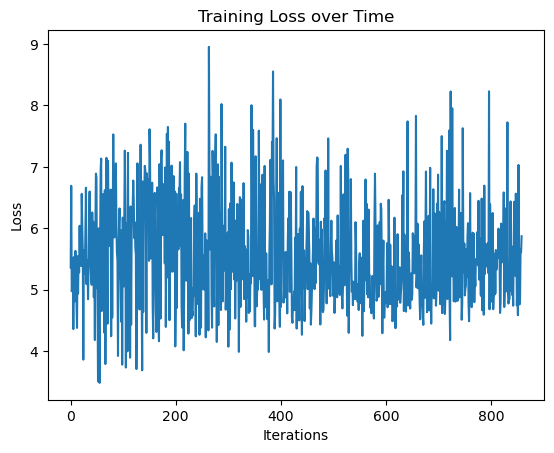

In [198]:
### Visualization of the loss ###

#Your code here
plt.plot(losses)
plt.title('Training Loss over Time')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

**Additional Notes and Tips**:

- Mac computers sometimes create .DS_STORE files inside of directories. If your training or testing loop breaks at a random time, it may be trying to load a hidden .DS_STORE file that it thinks is an image. Since they are hidden in the the Finder window, you will need to use the terminal to navigate to the data folder and use command `rm .DS_STORE`.

- If you want a good sense of how long your code is going to take to run, use the `tqdm` class to time the FOR loop.

-  ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

- This step could take several hours, so it is recommended that you save your model to a file every couple hundered steps to avoid losing work. You can find additional details on the [PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

- It is recommended that you save your loss plot as an image file in case you need to restart the training process.

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any of the gradients by using `torch.no_grad` in a with statement. You will aslo need to put the network into evaluation mode using `model.eval()`. For reference, to put the network back into training mode, call `model.train()`.

You will compare your predictions with the ground truth value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the **largest** value representing the guessed class.  You'll need to extract the guessed class number and compare it with the ground truth number for all images in the test dataset. Then you will calculate the overall accuracy of your predictor. While high test accuracy is not the only goal in this lab, most students are able to get above **50%** in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

Additionally, you will generate a confusion matrix of the 196 categories. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Large values that are not along the diagnol can help indicate categories that were hard to distinguish from each other (i.e. cars that look similar). A good blog post on the topic can be found [here](https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/).

To complete this part of the lab:
- Go through the testing dataset and make a list of all model predictions and a list of groundtruth labels.
- Using the two lists, calculate the total accuracy of the model and print this to the screen.
- Using the two lists, calculate and plot the confusion matrix for the test set.

In [199]:
### Task 4: Test the Network ###
import seaborn as sns
from sklearn.metrics import confusion_matrix


test_dataset = MyDataset("test_annos.json","cars_test", transform=transforms.Compose([transforms.Resize((256,256)),transforms.ToPILImage(),transforms.ToTensor()]))
test_loader = DataLoader(test_dataset,batch_size=32)

model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    # enter prediction and ground truth extraction code here
    for images, labels in test_loader:
        # Move images and labels to the device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        
        # Get predicted class for each sample 
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and ground truth labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Test Accuracy: 0.52%


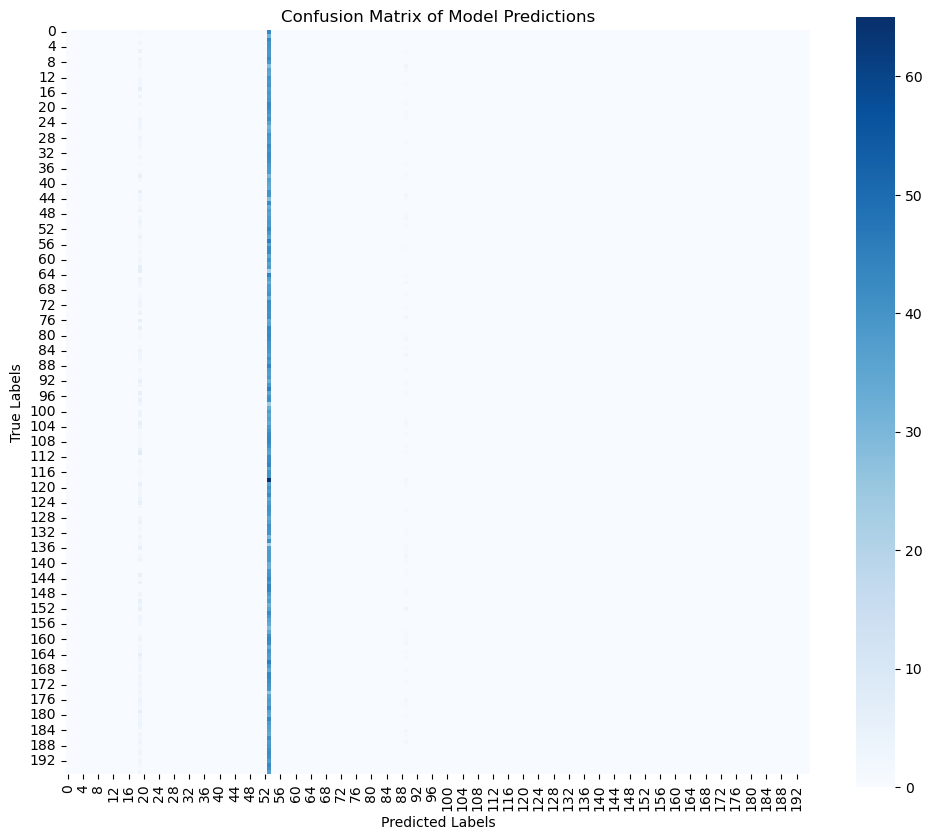

In [200]:
import numpy as np

# Accuracy calculation code here
accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion matrix visual 
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", square=True)
plt.title("Confusion Matrix of Model Predictions")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**Additional Notes and Tips**:
- You can write your test code before you fully train your model. For example, if your model takes a long time to train, train it for a few steps, stop it early, use the poorly trained model to debug your test code, then go back and train it fully later.

- For the confusion matrix calculations, it should be pretty easy to implement using a for loop and a np.zeros(196,196) buffer, but you are welcome to use sklearn's confusion matrix package if you prefer.

- For plotting the confusion matrix, you can simply use plt.imshow with interpolation off. If you want a nicer looking plot, you can the seaborn package with the heatmap function as described [here](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea). 

- It is recommended that you save your accuracy and your confusion matrix plot to file in case you need to restart the training process.

## Turning in your assignment

To turn in this assignment, turn in this notebook with the following pieces:
- Code for the dataset loader, the neural network, the training loop, and testing.
- A visual of the loss value plotted over time during the training.
- A print out of the accuracy on the test set.
- A visual of the confusion matrix on the test set.

**DO NOT TURN IN:**
- The dataset files
- The saved neural network weights

These files are too large to upload to Canvas, and students who fail to follow these instructions will be docked points. Also, the graders will not rerun your training loop from scratch, so make sure all the visuals are visible on your notebook when you submit.

If you chose to run your code from the .py file, please submit your code as one file and screenshots of the loss value plot, accuracy, and confusion matrix separately.

### Extra Credit Competition (5 pts)

An additional 5 pts of extra credit will be given to the individual with the highest test accuracy. You can try to improve the accuracy of your network using strategies such as data augmentation, learning rate schedulers, or different optimizers and batch sizes.